In [5]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import label_ranking_average_precision_score
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import math

In [6]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
encoder = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [7]:
genreToIndex = {
    "Drama": 0,
    "Comedy": 1,
    "Thriller": 2,
    "Action": 3,
    "Romance": 4,
    "Adventure": 5,
    "Crime": 6,
    "Science Fiction": 7,
    "Horror": 8,
    "Family": 9,
    "Fantasy": 10,
    "Mystery": 11,
    "Animation": 12,
    "History": 13,
    "Music": 14,
    "War": 15,
    "Documentary": 16,
    "Western": 17,
    "Foreign": 18,
    "TV Movie": 19
}

indexToGenre = [
    "Drama",
    "Comedy",
    "Thriller",
    "Action",
    "Romance",
    "Adventure",
    "Crime",
    "Science Fiction",
    "Horror",
    "Family",
    "Fantasy",
    "Mystery",
    "Animation",
    "History",
    "Music",
    "War",
    "Documentary",
    "Western",
    "Foreign",
    "TV Movie"
]

In [8]:
# make sure to change this for your path
df = pd.read_csv('tmdb.csv')
df.head(1)

,Unnamed: 0,budget,genres,homepage,id,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [9]:
def one_hot_encode_genres(df):
  labels = []
  for genres in df["genres"]:
    genreList = json.loads(genres)
    label = [0 for _ in range(len(indexToGenre))]
    for genre in genreList:
      genreName = genre["name"]
      genreIndex = genreToIndex[genreName]
      label[genreIndex] = 1
    labels.append(label)
  return labels

In [10]:
def get_keywords(df):
  keyword_entries = []
  for keywords in df['keywords']:
    keywords_list = json.loads(keywords)
    current_keywords = ' '.join([keyword['name'] for keyword in keywords_list])
    keyword_entries.append(current_keywords)
  return pd.Series(keyword_entries)

In [11]:
def build_df(df, column_names):
  # filling missing values (overview, tagline, runtime)
  features = []
  overviews = df["overview"].fillna("")
  taglines = df["tagline"].fillna("")
  keywords = get_keywords(df)
  titles = df["title"]
  
  text_col = np.array(encoder(overviews + taglines + keywords + titles))
  features.append(list(text_col))

  runtime_avg = df['runtime'].mean()
  features.append(list(df["runtime"].fillna(runtime_avg)))
  features.append(list(df["popularity"]))
  
  vote_avg_avg = df['vote_average'].mean()
  features.append(list(df["vote_average"].fillna(vote_avg_avg)))
  vote_count_avg = df['vote_count'].mean()
  features.append(list(df["vote_count"].fillna(vote_count_avg)))

  # OHC for labels
  features.append(one_hot_encode_genres(df))

  new_df = pd.DataFrame()
  for i in range(len(features)):
    column = column_names[i]
    new_df[column] = features[i]

  return new_df

In [12]:
def show_confusion_graph(y_true, y_pred):
  cols = 4
  conf_mat = multilabel_confusion_matrix(y_true, y_pred)
  genres_count = len(indexToGenre)
  figures_count = int(math.ceil(genres_count / cols))
  for figure_idx in range(figures_count):
    fig, axs = plt.subplots(1, cols, figsize=(16, 3))
    genre_idx = figure_idx * cols
    offset = 0
    while offset < cols and genre_idx + offset < genres_count:
      col = offset
      mat = conf_mat[genre_idx + offset]
      tn = mat[0, 0] # True Negatives
      fp = mat[0, 1] # False Positives
      fn = mat[1, 0] # False Negatives
      tp = mat[1, 1] # True Positives
      names = ["TP", "FP", "FN", "TN"]
      values = [tp, fp, fn, tn]
      axs[col].bar(names, values)
      axs[col].set_title(indexToGenre[genre_idx + offset])
      offset += 1
    plt.show()

def show_confusion_matrix(y_true, y_pred):
    print("Confusion Matrix for each genre")
    print("Format: ")
    print(np.array([["True Positives", "False Positives"],
                    ["False Negatives", "True Negatives"]]))
    conf_mat = multilabel_confusion_matrix(y_true, y_pred)
    for i in range(len(indexToGenre)):
      genre = indexToGenre[i]
      mat = conf_mat[i]
      tn = mat[0, 0] # True Negatives
      fp = mat[0, 1] # False Positives
      fn = mat[1, 0] # False Negatives
      tp = mat[1, 1] # True Positives
      print()
      print(genre)
      print(np.array([[tp, fp], [fn, tn]]))

In [13]:
def train_models(X, y, models):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

  trained_models = []
  for model in models:
    print(f"Training {type(model['model']).__name__}...")
    training_result = OneVsRestClassifier(model['model']).fit(X_train, y_train)
    trained_models.append(training_result)
  
  return X_train, X_test, y_train, y_test, trained_models

In [14]:
def test_models(X_test, y_test, trained_models):
  for model in trained_models:
    y_predict = model.predict(X_test)
    score = label_ranking_average_precision_score(y_test, y_predict)
    print(f"{type(model.estimator).__name__} tested with score: {score}")

    show_confusion_graph(y_test, y_predict)
    #show_confusion_matrix(y_test, y_predict)

In [15]:
new_df = build_df(
    df,
    ['text', 'runtime', 'popularity', 'vote_average', 'vote_count', 'genres']
)
new_df

,text,runtime,popularity,vote_average,vote_count,genres
0,"[-0.047631502, 0.0011049577, -0.003003196, -0....",162.0,150.437577,7.2,11800,"[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, ..."
1,"[-0.029288009, -0.024092462, -0.03336971, -0.0...",169.0,139.082615,6.9,4500,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
2,"[-0.01410443, 0.019948822, -0.06397616, -0.052...",148.0,107.376788,6.3,4466,"[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0.010828347, -0.038507707, -0.007529563, -0.0...",165.0,112.312950,7.6,9106,"[1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[-0.04910142, 0.028201548, -0.02816448, -0.016...",132.0,43.926995,6.1,2124,"[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
4770,"[-0.053809155, 0.01764537, 0.054941926, 0.0080...",80.0,0.022173,7.5,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4771,"[-0.02244055, 0.02026401, 0.06935676, -0.00409...",81.0,14.269792,6.6,238,"[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4772,"[0.019236596, 0.055466358, -0.014909613, -0.00...",85.0,0.642552,5.9,5,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4773,"[-0.05435342, -0.06341675, -0.06609998, -0.009...",120.0,1.444476,7.0,6,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
text = np.array(new_df['text'].tolist())
popularity = pd.DataFrame(new_df['popularity'])
runtime = pd.DataFrame(new_df['runtime'])
vote_average = pd.DataFrame(new_df['vote_average'])
vote_count = pd.DataFrame(new_df['vote_count'])

X_basic = np.concatenate((text, popularity, runtime), axis=1)
X_full = np.concatenate((text, popularity, runtime, vote_average, vote_count), axis=1)

# formatting y for OneVsRestClassifier
y = np.array(list(new_df["genres"]))

In [17]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.metrics import label_ranking_average_precision_score, multilabel_confusion_matrix

In [18]:
models = [
  {
    "model": DecisionTreeClassifier(),
    "params": {
      "estimator__criterion": ["gini", "entropy"]
    },
  },
  {
    "model": SVC(),
    "params": {
      "estimator__kernel": ["linear", "poly", "rbf", "sigmoid"]
    },
  },
  {
    "model": MLPClassifier(max_iter=1000),
    "params": {
      "estimator__hidden_layer_sizes": [(50, 50, 50), (50, 100, 50), (100, 1)],
      "estimator__activation": ["relu", "tanh", "logistic"],
      "estimator__alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
      "estimator__learning_rate": ["constant", "adaptive"],
    },
  },
  {
    "model": KNeighborsClassifier(),
    "params": {
      "estimator__n_neighbors": [5, 10, 15],
      "estimator__weights": ["uniform", "distance"],
      "estimator__algorithm": ["ball_tree", "kd_tree"]
    },
  },
  {
    "model": RandomForestClassifier(),
    "params": {
      "estimator__n_estimators": [100, 200, 300]
    },
  },
  {
    "model": SGDClassifier(),
    "params": {
      "estimator__loss": ["hinge", "log", "modified_huber"],
      "estimator__alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
      "estimator__learning_rate": ["constant", "optimal", "adaptive"],
    },
  },
  {
    "model": RidgeClassifier(),
    "params": {
      "estimator__alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1],
    },
  },
]

In [19]:
def grid_search_model(model, params, X_train, X_test, y_train, y_test):
  searcher = GridSearchCV(
      estimator=OneVsRestClassifier(model), 
      param_grid=params,
      scoring=label_ranking_average_precision_score,
      n_jobs=-1,
      verbose=5
  )
  result = searcher.fit(X_train, y_train)
  model = result.best_estimator_
  score = searcher.best_score_

  print(f"{type(model.estimator).__name__} grid searched finished with score: {score} and params: {searcher.best_params_}")
  return model

In [20]:
def grid_search_all_models(X, y, models):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

  best_models = []
  for model in models:
    best_model = grid_search_model(model["model"], model["params"], X_train, X_test, y_train, y_test)
    best_models.append(best_model)

  return X_train, X_test, y_train, y_test, best_models

In [22]:
do_grid_search = False

if do_grid_search:
  # Train the models on the small feature set
  X_basic_train, X_basic_test, y_basic_train, y_basic_test, basic_trained_models = grid_search_all_models(X_basic, y, models)
  # Train the models on the extended feature set
  X_train, X_test, y_train, y_test, trained_models = grid_search_all_models(X_full, y, models)
else:
  # Train the models on the small feature set
  X_basic_train, X_basic_test, y_basic_train, y_basic_test, basic_trained_models = train_models(X_basic, y, models)
  # Train the models on the extended feature set
  X_train, X_test, y_train, y_test, trained_models = train_models(X_full, y, models)

Training DecisionTreeClassifier...
Training SVC...
Training MLPClassifier...
Training KNeighborsClassifier...
Training RandomForestClassifier...
Training SGDClassifier...
Training RidgeClassifier...
Training DecisionTreeClassifier...
Training SVC...
Training MLPClassifier...
Training KNeighborsClassifier...
Training RandomForestClassifier...
Training SGDClassifier...
Training RidgeClassifier...


DecisionTreeClassifier tested with score: 0.3655384775201538


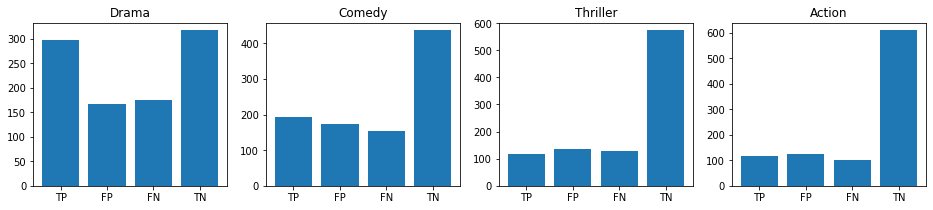

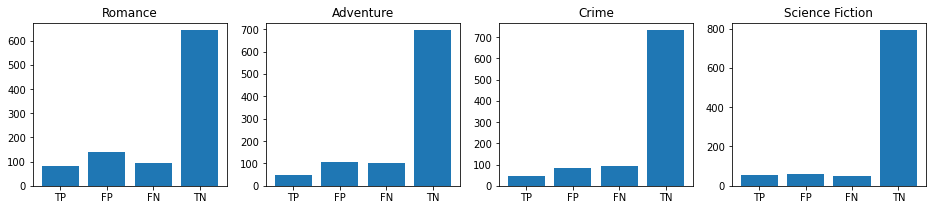

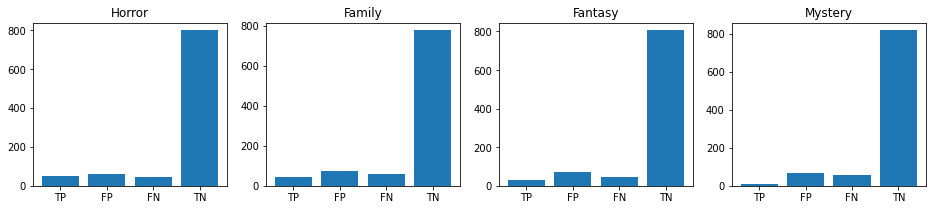

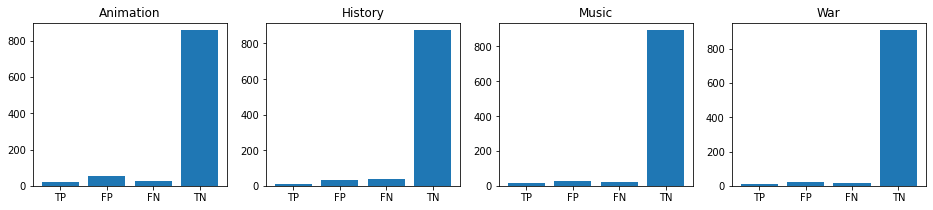

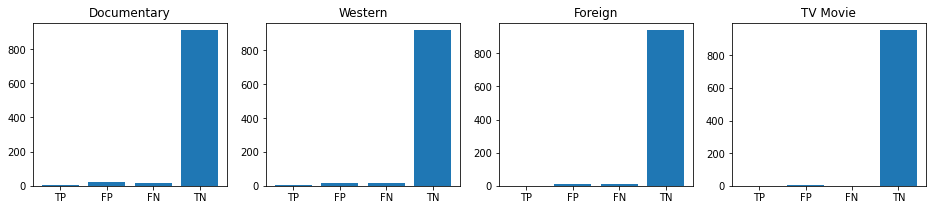

SVC tested with score: 0.2594851657940673


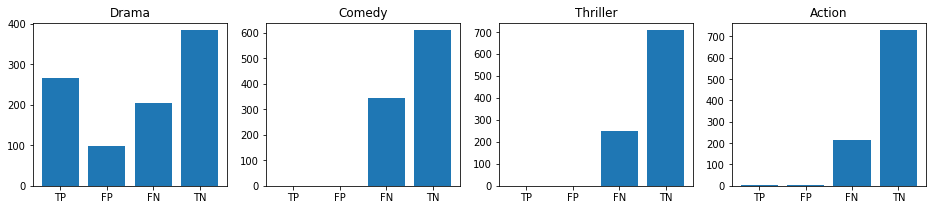

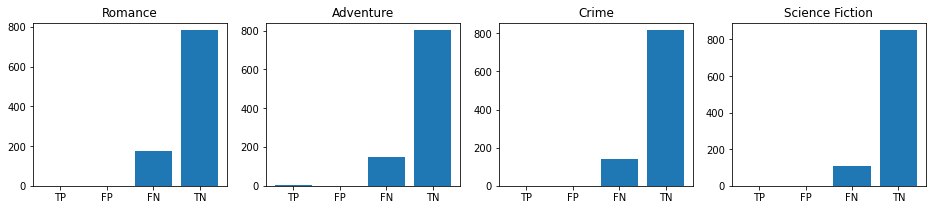

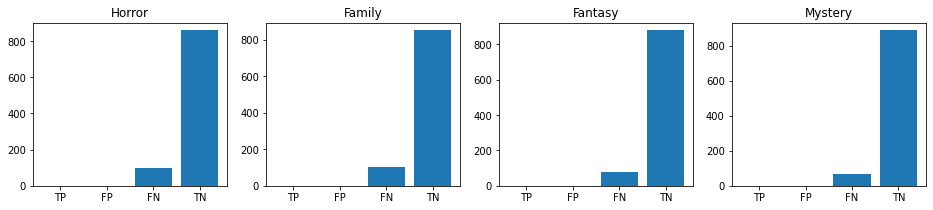

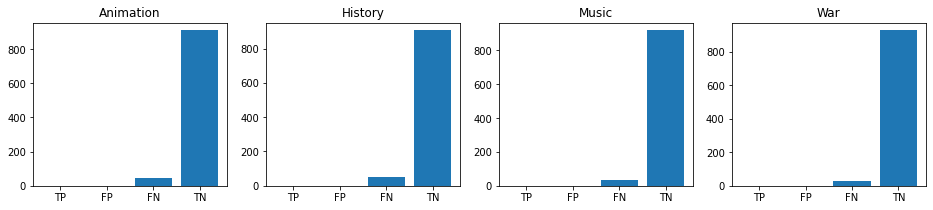

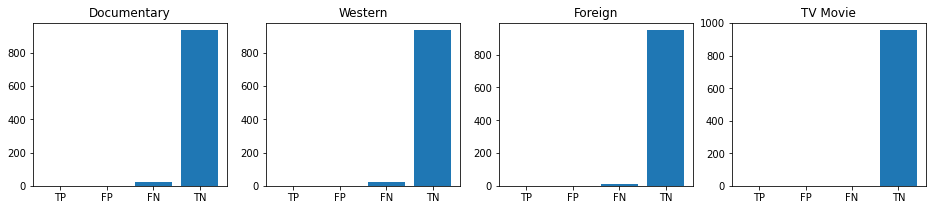

MLPClassifier tested with score: 0.5281064572425838


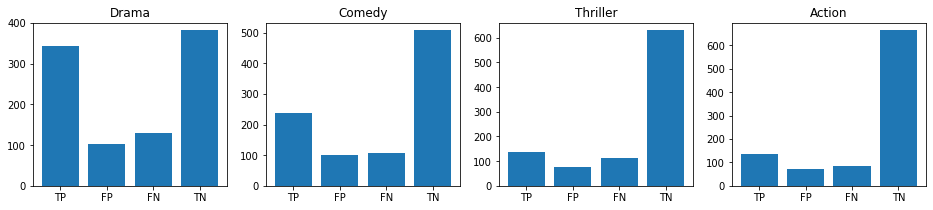

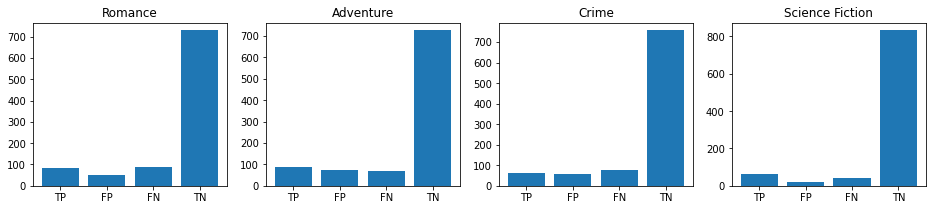

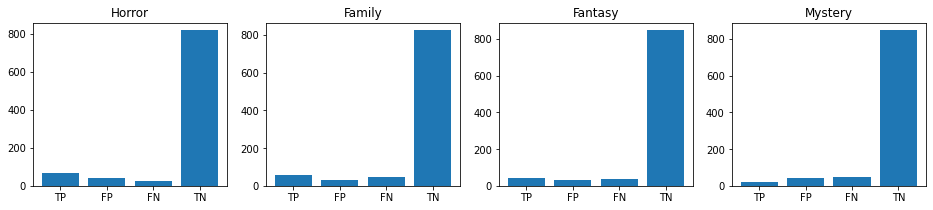

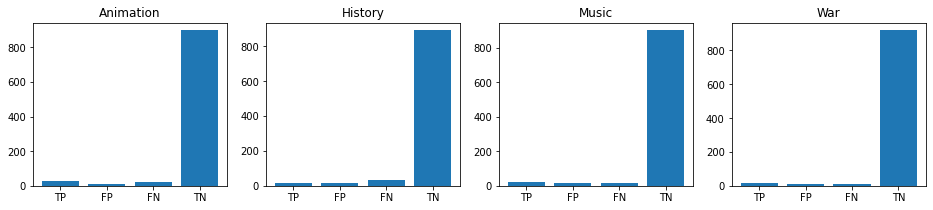

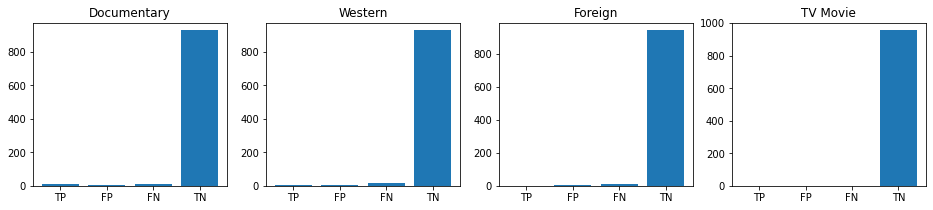

KNeighborsClassifier tested with score: 0.32971931355439327


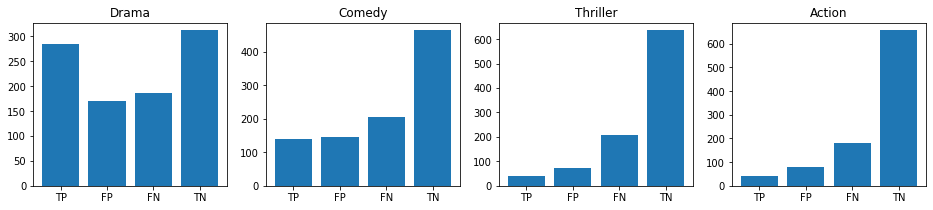

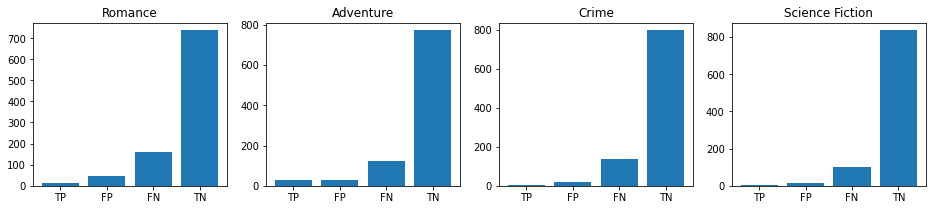

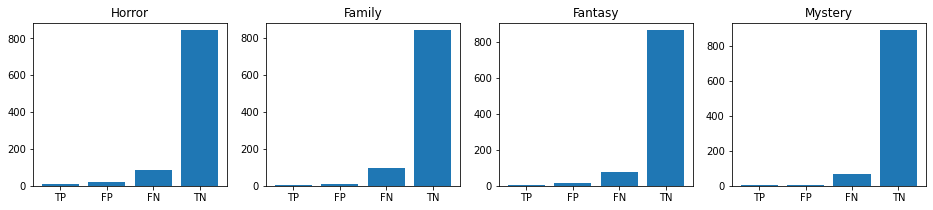

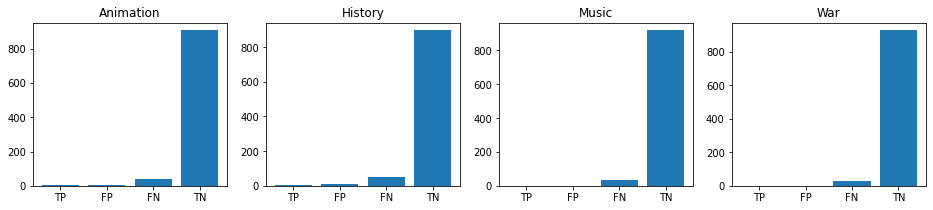

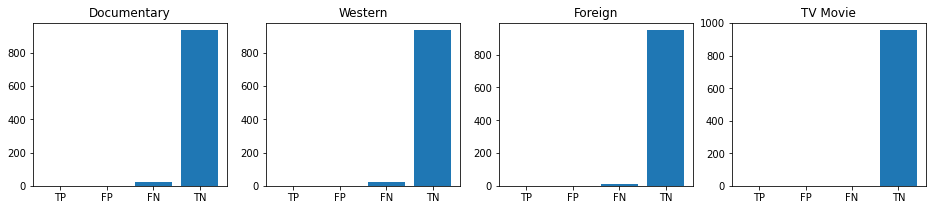

RandomForestClassifier tested with score: 0.45696625945317143


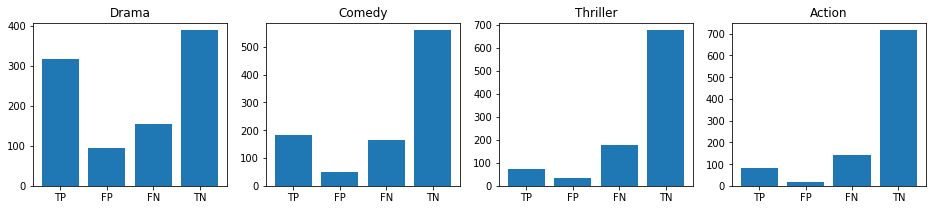

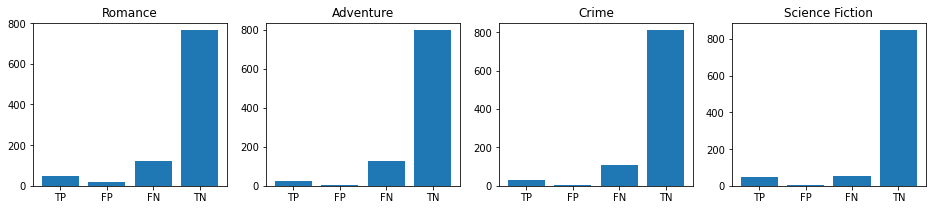

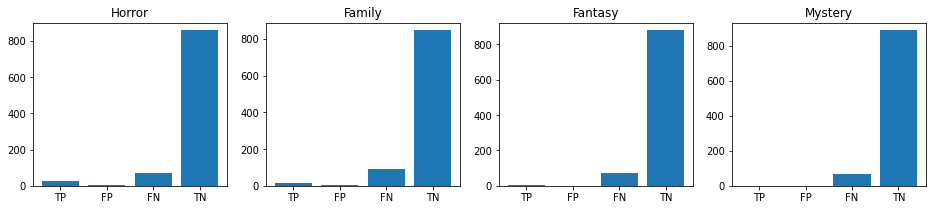

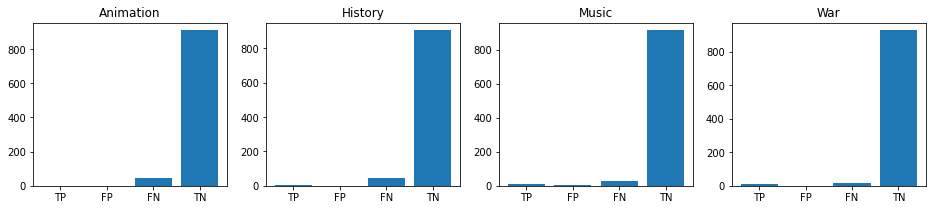

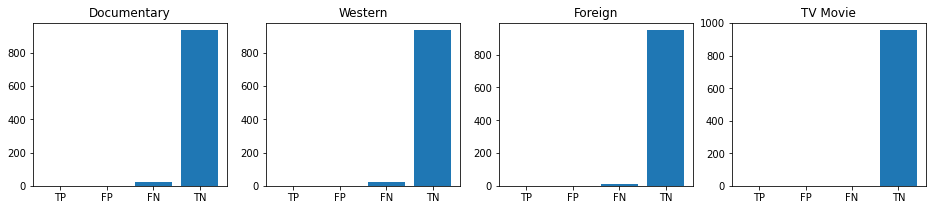

SGDClassifier tested with score: 0.20731667082190713


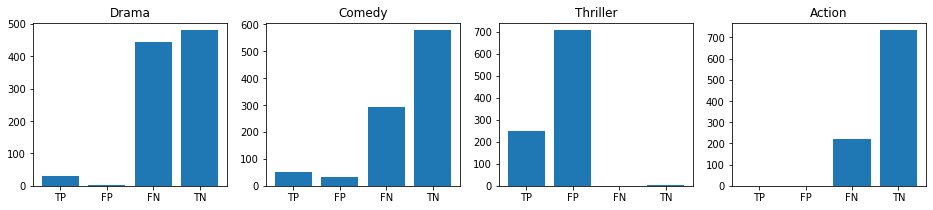

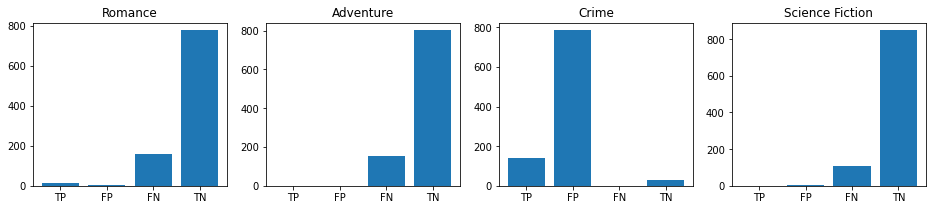

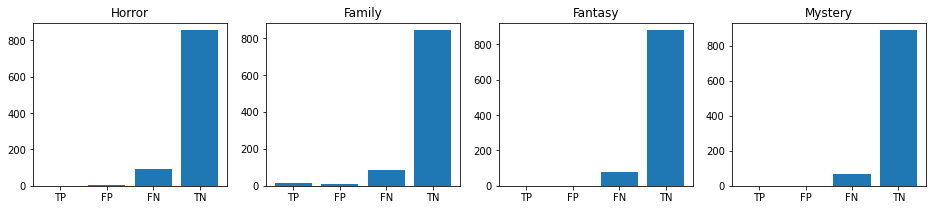

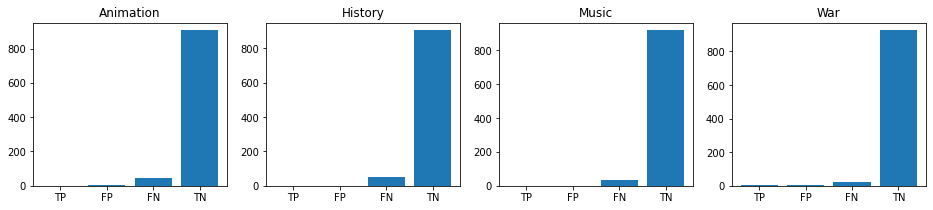

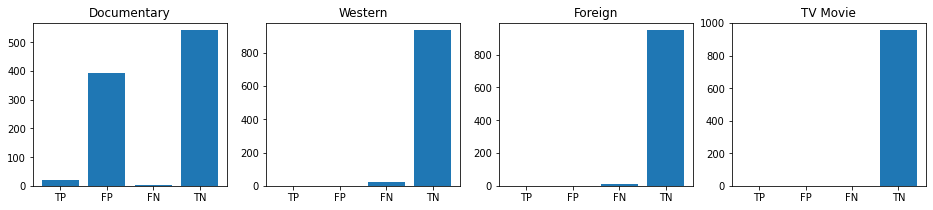

RidgeClassifier tested with score: 0.540065445026179


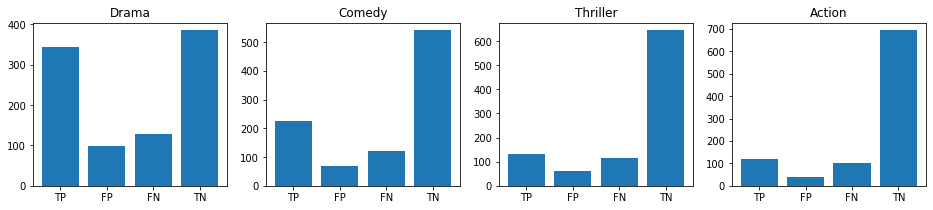

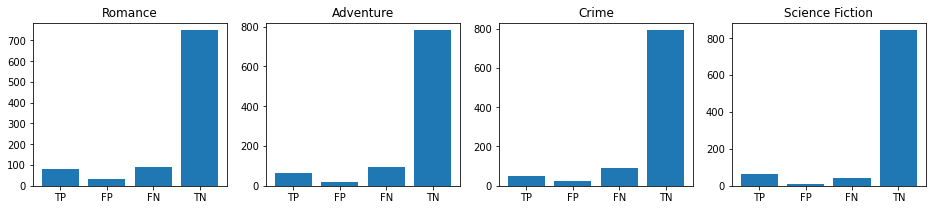

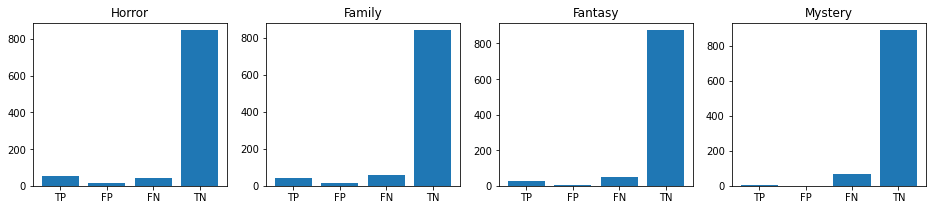

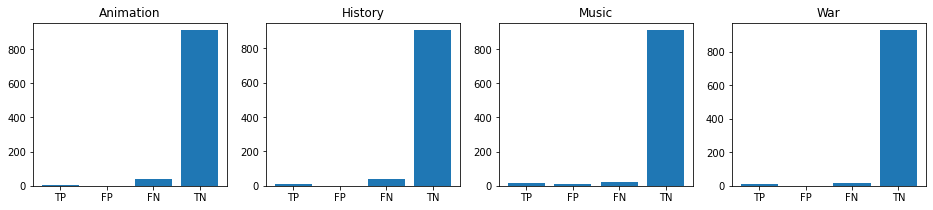

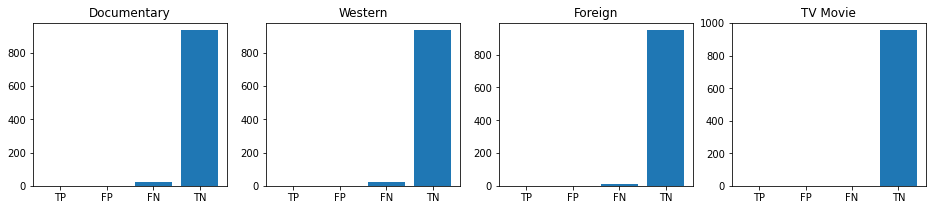

In [23]:
# Test the models on the small feature set
test_models(X_basic_test, y_basic_test, basic_trained_models)

DecisionTreeClassifier tested with score: 0.3649950137122921


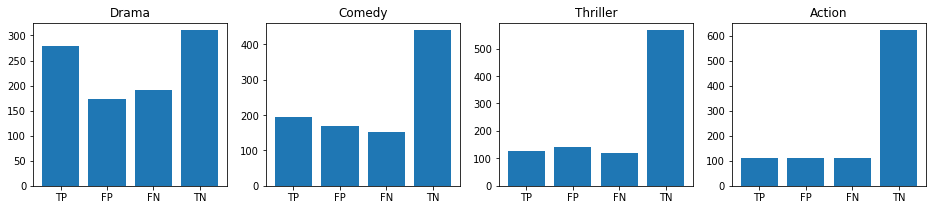

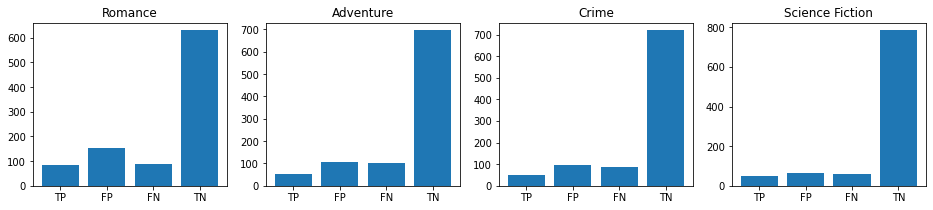

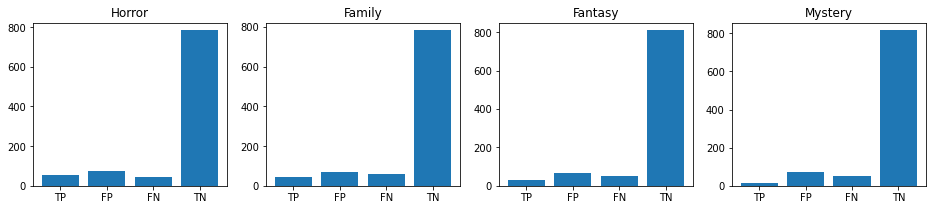

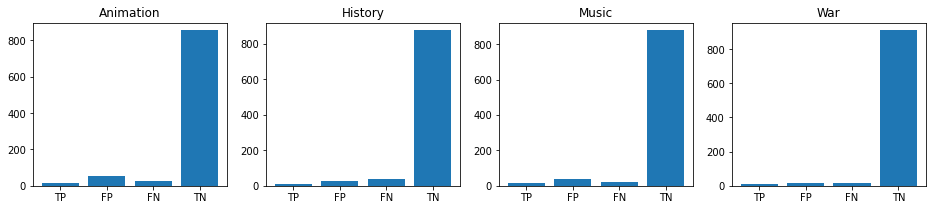

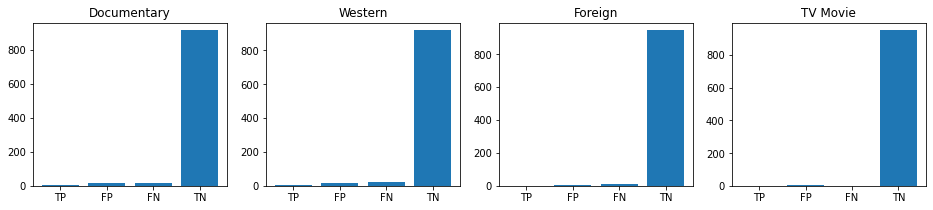

SVC tested with score: 0.2797120418848179


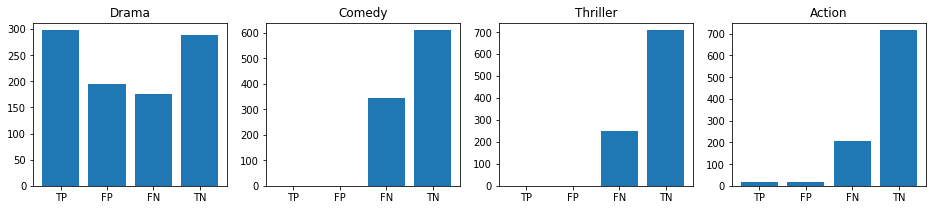

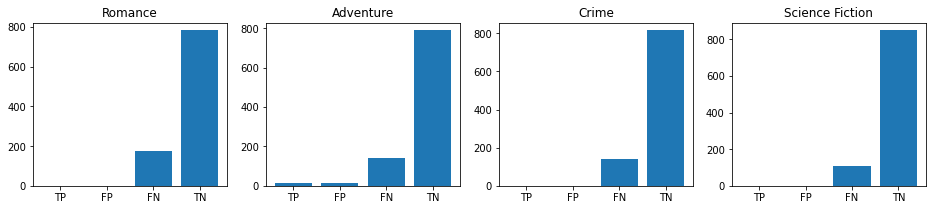

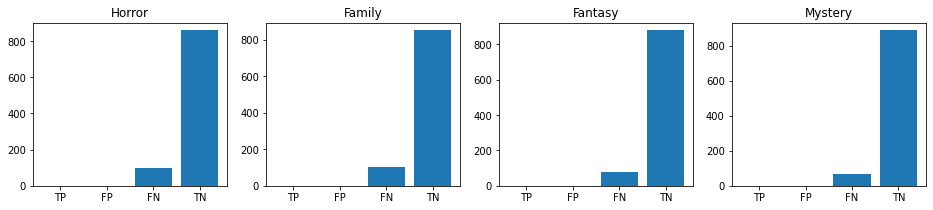

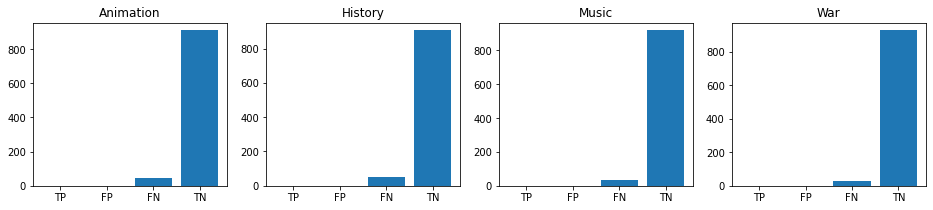

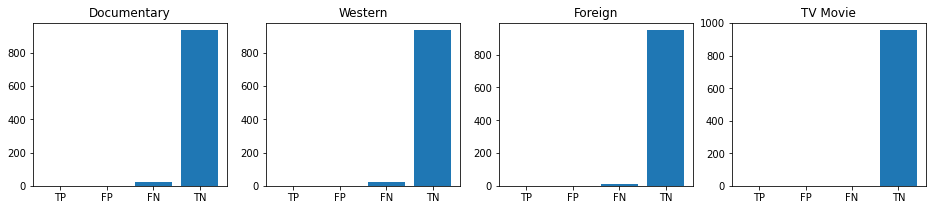

MLPClassifier tested with score: 0.5061896866949237


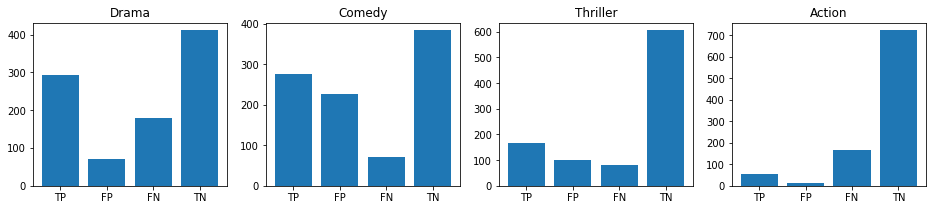

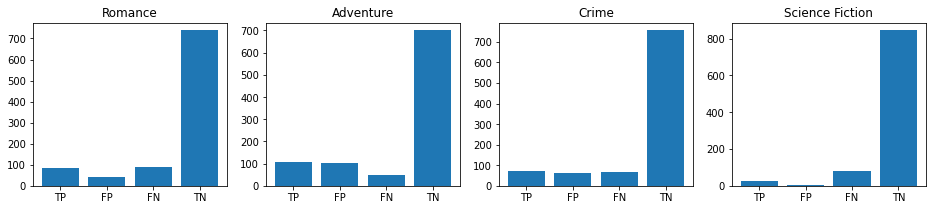

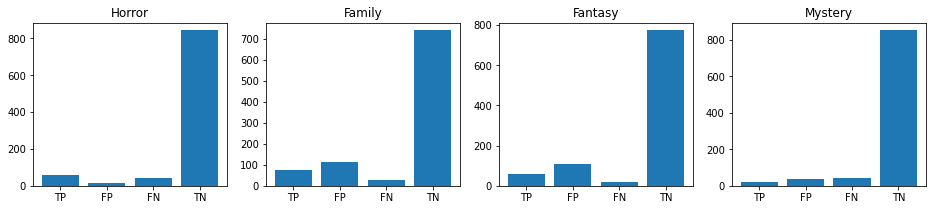

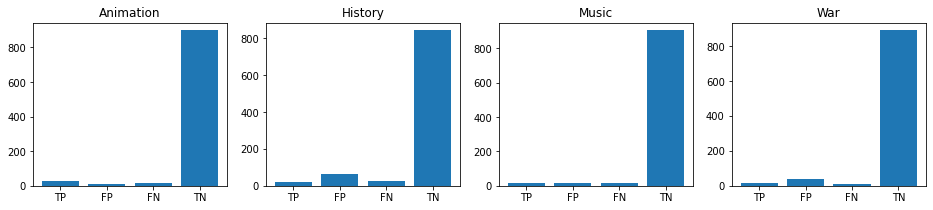

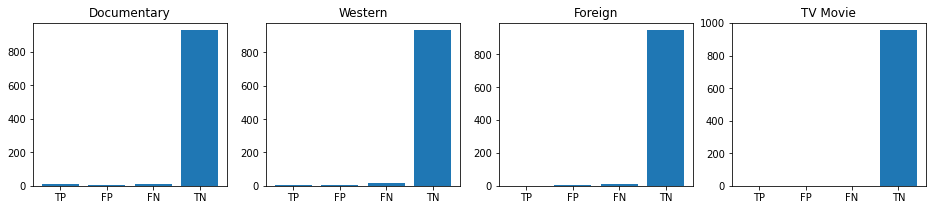

KNeighborsClassifier tested with score: 0.3117044793484597


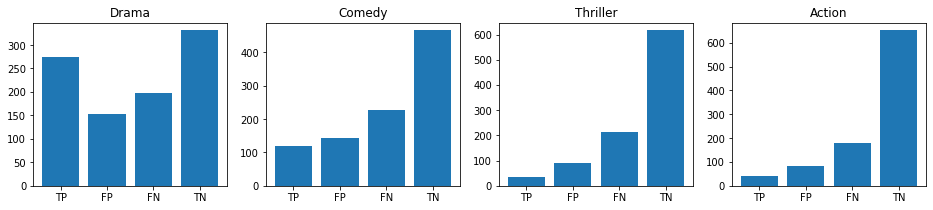

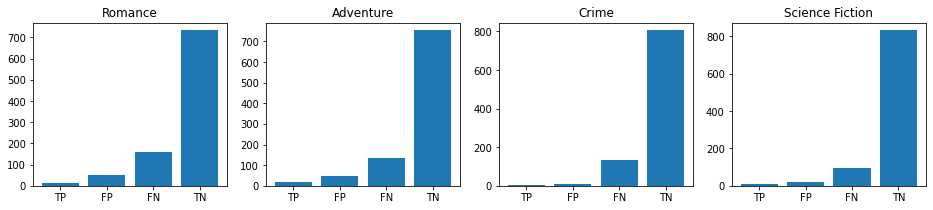

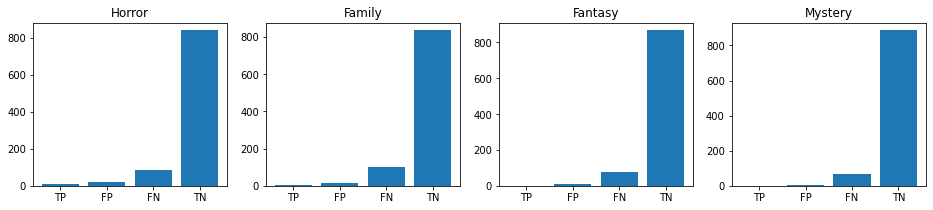

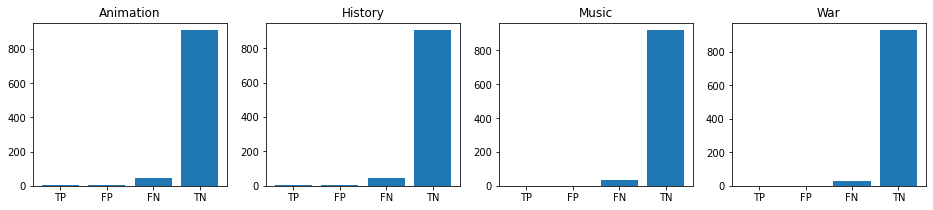

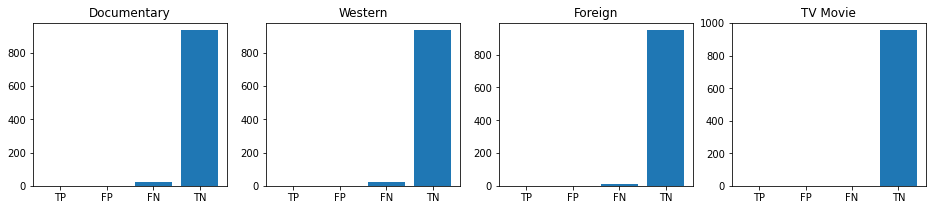

RandomForestClassifier tested with score: 0.46768615474112957


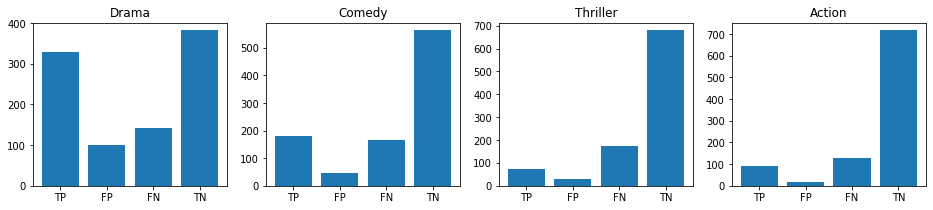

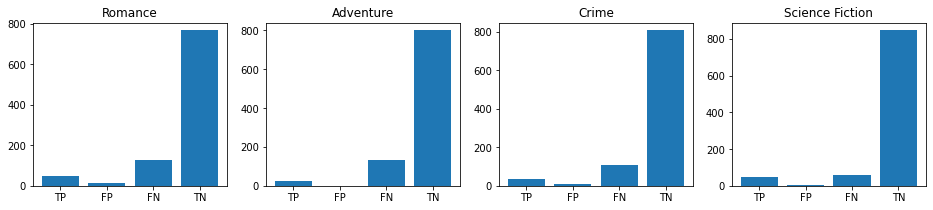

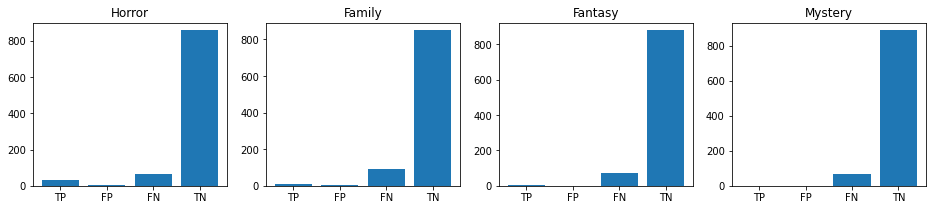

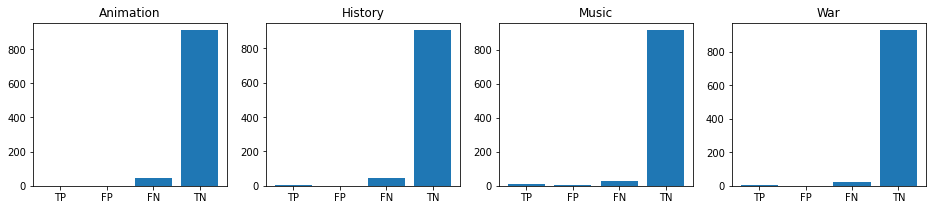

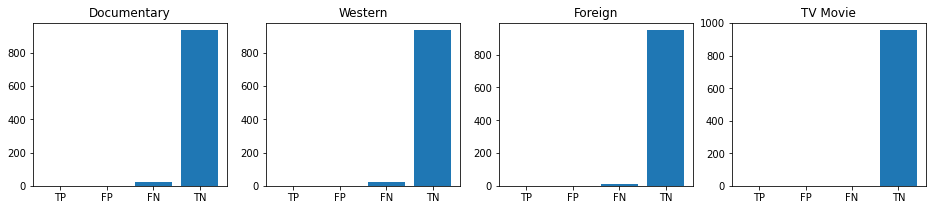

SGDClassifier tested with score: 0.15935427574171057


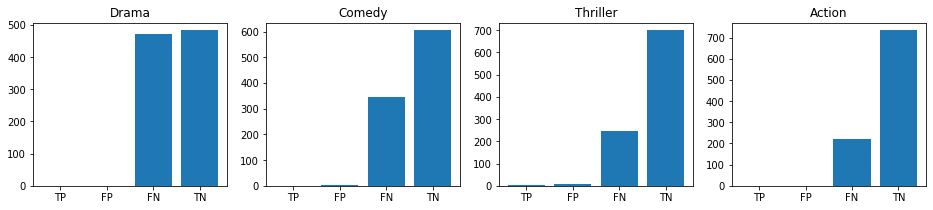

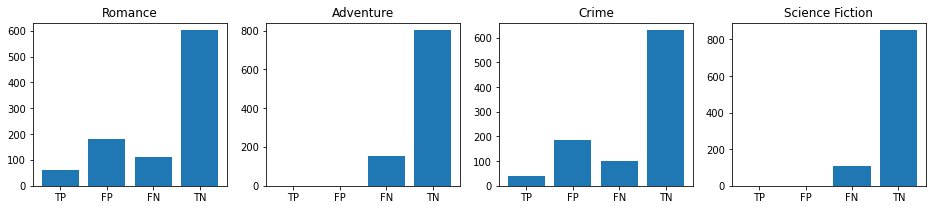

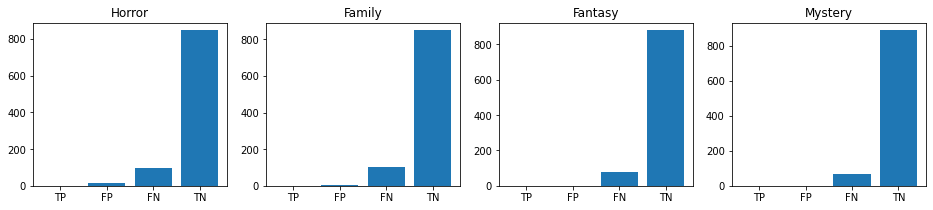

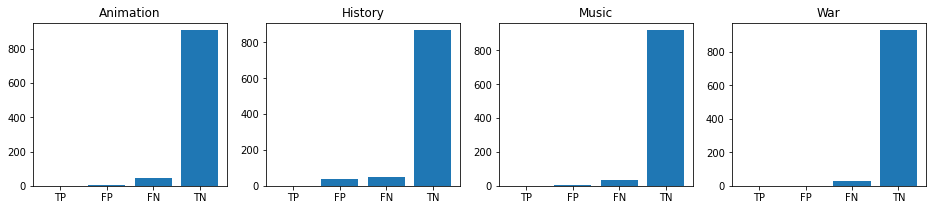

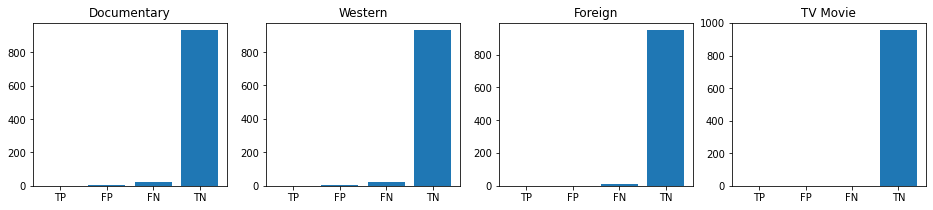

RidgeClassifier tested with score: 0.5389790575916241


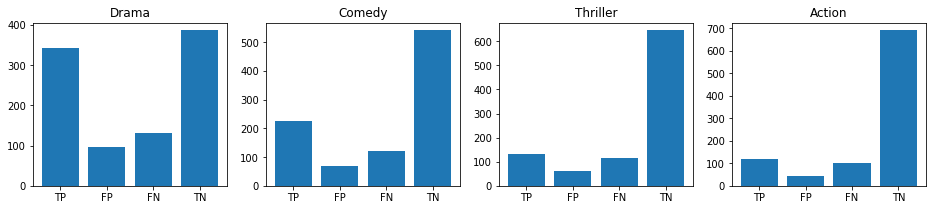

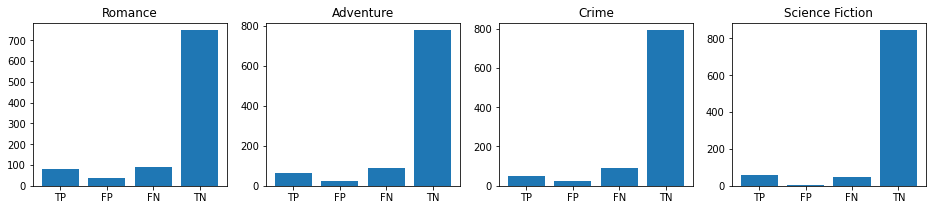

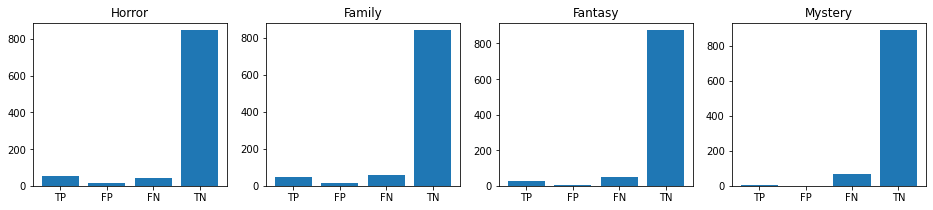

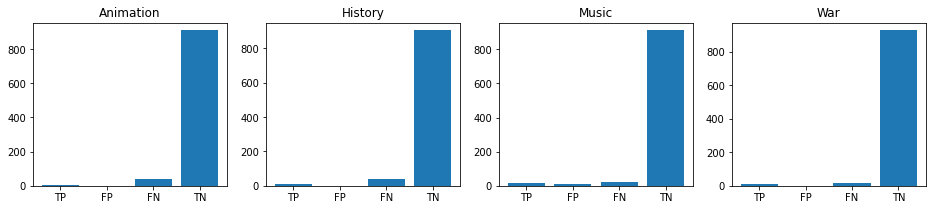

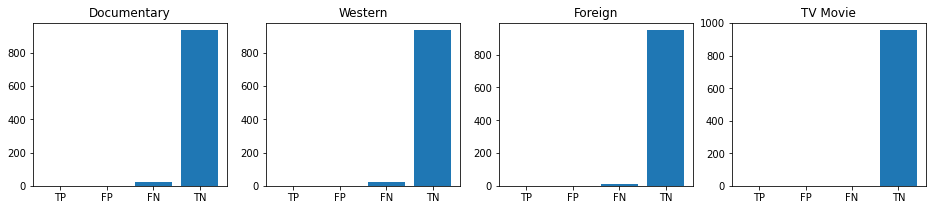

In [24]:
# Test the models on the extended feature set
test_models(X_test, y_test, trained_models)